In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import cv2
import os
from sklearn.metrics import mean_squared_error as mse
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import accuracy_score 


In [2]:
def load_image(path):                                                      
    image_gs = cv2.imread(path, cv2.IMREAD_GRAYSCALE)       # Load the eye image and convert to grayscale

    folder_path, filename = os.path.split(path)             # Get the image path

    return image_gs, folder_path, filename


In [3]:
main_folder_path = '../DIP-Project/MMU-Iris-Database_Preprocessed'

In [4]:
def getreshapedimages(num_classes , ext = 'Eq.bmp'):
    reshaped_images = []
    image_labels = []

    # sorted_subfolders = sorted(os.listdir(main_folder_path))
    # sort after converting to integers
    sorted_subfolders = sorted(os.listdir(main_folder_path), key=lambda f: int(''.join(filter(str.isdigit, f))))

    for subfolder_name in sorted_subfolders:
        subfolder_path = os.path.join(main_folder_path, subfolder_name)

        if int(subfolder_name) - 1> num_classes:
            break
        # 1,2,...., 46
        if os.path.isdir(subfolder_path):
            for sub_subfolder_name in os.listdir(subfolder_path):
                
                sub_subfolder_path = os.path.join(subfolder_path, sub_subfolder_name)

                # left, right
                if os.path.isdir(sub_subfolder_path):
                    for image_name in os.listdir(sub_subfolder_path):
                        image_path = os.path.join(sub_subfolder_path, image_name)
                        
                        # Checking if file name ends with the required
                        # We change the images to be taken here.
                        if image_name.endswith(ext):
                            image_gs, eye_folder_path, eye_filename = load_image(image_path)
                            # image_gs = image_gs.reshape(image_gs.shape[0]*image_gs.shape[1])

                            reshaped_images.append(image_gs)
                            image_labels.append(subfolder_name)
    reshaped_images = np.array(reshaped_images)
    image_labels = np.array(image_labels)
    
    return reshaped_images, image_labels

In [5]:
# Split into train and test for each class
def split(reshaped_images, image_labels):
    train_images = []
    train_labels = []

    test_images = []
    test_labels = []

    for i in range(0, len(reshaped_images), 10):
        for j in range(10):
            if j < 9:
                train_images.append(reshaped_images[i+j])
                train_labels.append(image_labels[i+j])
            else:
                test_images.append(reshaped_images[i+j])
                test_labels.append(image_labels[i+j])
    
    train_images = np.array(train_images)
    train_labels = np.array(train_labels)

    test_images = np.array(test_images)
    test_labels = np.array(test_labels)
    return train_images, train_labels, test_images, test_labels

In [6]:
def pca_v_numfeats(n_pca, n_step , ext = 'Eq.bmp'):
  n_classes = 45

  reshaped_images, image_labels = getreshapedimages(n_classes , ext)
  train_images, train_labels, test_images, test_labels = split(reshaped_images, image_labels)

  X_train = train_images.reshape(train_images.shape[0], train_images.shape[1]*train_images.shape[2])  
  # print(X_train.shape)
  X_test = test_images.reshape(test_images.shape[0], test_images.shape[1]*test_images.shape[2])
  y_train = train_labels
  y_test = test_labels

  num_components_pca = n_pca
  pca = PCA(n_components=num_components_pca)
  X_train_pca = pca.fit_transform(X_train)
  X_test_pca = pca.transform(X_test)

  accuracy = []
  num_features =[]

  for i in range(5, num_components_pca, n_step):
    num_features.append(i)
    num_components_lda = min(n_classes - 1, i)
    lda = LDA(n_components=num_components_lda)

    X_train_lda = lda.fit_transform(X_train_pca[:,:i], y_train)
    X_test_lda = lda.transform(X_test_pca[:,:i])

    acc = lda.score(X_test_pca[:,:i], y_test)
    accuracy.append(acc)


  return num_features, accuracy

In [7]:
def varying_numclass(n_class , ext = 'Eq.bmp'):
    num_classes = []
    accuracy = []

    for i in range(9, n_class, 5):
        reshaped_images, image_labels = getreshapedimages(i , ext)
        train_images, train_labels, test_images, test_labels = split(reshaped_images, image_labels)

        X_train = train_images.reshape(train_images.shape[0], train_images.shape[1]*train_images.shape[2])  
        X_test = test_images.reshape(test_images.shape[0], test_images.shape[1]*test_images.shape[2])
        y_train = train_labels
        y_test = test_labels

        num_components_pca = min(100 , X_train.shape[0])
        pca = PCA(n_components=num_components_pca)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)

        num_components_lda = min(i - 1, num_components_pca)
        lda = LDA(n_components=num_components_lda)

        X_train_lda = lda.fit_transform(X_train_pca[:,:num_components_pca], y_train)
        X_test_lda = lda.transform(X_test_pca[:,:num_components_pca])

        acc = lda.score(X_test_pca[:,:num_components_pca], y_test)        
        accuracy.append(acc)
        num_classes.append(i)

    return num_classes, accuracy

In [8]:
n, acc_hist = pca_v_numfeats(201, 10)
n , acc_parabolic = pca_v_numfeats(201, 10, 'Parabolic.bmp')
n , acc_rubber = pca_v_numfeats(201, 10, 'Rubber.bmp')

(-0.5, 899.5, 599.5, -0.5)

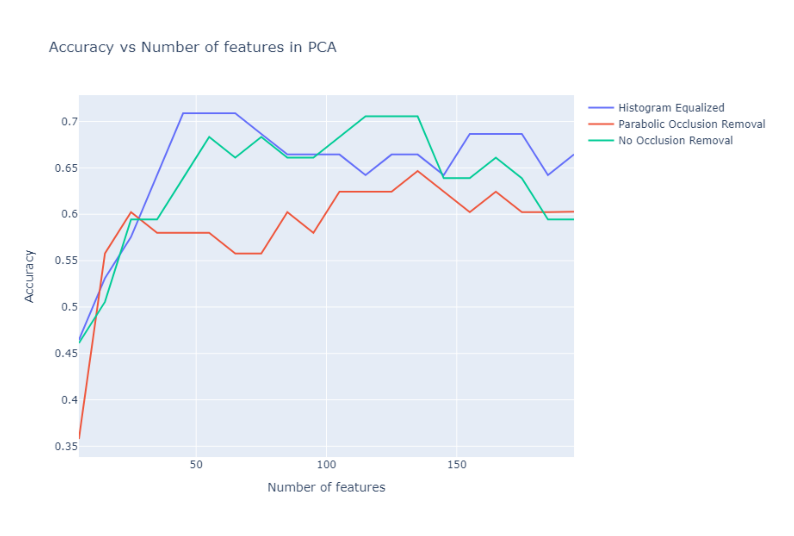

In [24]:
# Plotting the accuracy for all 3 acc_hist , acc_parabolic , acc_rubber in 1 graph
fig = go.Figure()
fig.add_trace(go.Scatter(x=n, y=acc_hist,
                    mode='lines',
                    name='Histogram Equalized'))
fig.add_trace(go.Scatter(x=n, y=acc_parabolic,
                    mode='lines',
                    name='Parabolic Occlusion Removal '))
fig.add_trace(go.Scatter(x=n, y=acc_rubber,
                    mode='lines',
                    name='No Occlusion Removal'))

fig.update_layout(title='Accuracy vs Number of features in PCA',    
                   xaxis_title='Number of features',
                   yaxis_title='Accuracy' , width=900 , height=600)  
fig.show()

In [10]:
num_classes, acc_hist = varying_numclass(45)
num_classes, acc_parabolic = varying_numclass(45, 'Parabolic.bmp')
num_classes, acc_rubber = varying_numclass(45, 'Rubber.bmp')

(-0.5, 899.5, 599.5, -0.5)

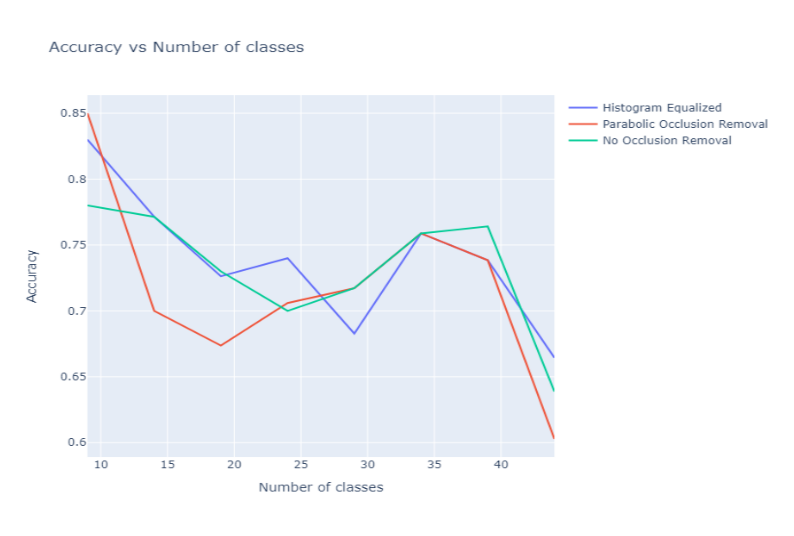

In [25]:
# Plotting the accuracy for all 3 acc_hist , acc_parabolic , acc_rubber in 1 graph
fig = go.Figure()
fig.add_trace(go.Scatter(x=num_classes, y=acc_hist,
                    mode='lines',
                    name='Histogram Equalized'))
fig.add_trace(go.Scatter(x=num_classes, y=acc_parabolic,
                    mode='lines',
                    name='Parabolic Occlusion Removal'))
fig.add_trace(go.Scatter(x=num_classes, y=acc_rubber,
                    mode='lines',
                    name='No Occlusion Removal'))

fig.update_layout(title='Accuracy vs Number of classes',
                     xaxis_title='Number of classes',
                     yaxis_title='Accuracy' , width = 800 , height = 600)
fig.show()